<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/4.2%20Distance%20Estimation%20Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import numpy as np
import pylab
import math

import astropy.units as u
import matplotlib.pyplot as plt

from pycbc import waveform
from pycbc.waveform import get_td_waveform, get_fd_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

import seaborn as sns
import time

     |████████████████████████████████| 3.1MB 4.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5MB 110kB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 1.0MB 16.4MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 1.6MB 29.9MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 3.2MB 30.4MB/s 


In [ ]:
## Create waveform function (taken from Section 3.1)

def create_waveform(mass1=30, mass2=30, spin1=[0, 0, 0], spin2=[0, 0, 0], resolution=1.0/1024, frequencybound=20, distance=500, cosmology=Planck18, approximant="IMRPhenomPv2"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  lum_dist = cosmology.luminosity_distance(redshift-1)
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant=approximant,
                                             mass1=mass1, mass2=mass2,
                                             spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                             spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/lum_dist for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Create frequency series waveform function (for expectation value function)

def create_fd_waveform(mass1, mass2, spin1, spin2, fres, flow, dist, cosmology=Planck18, approximant="IMRPhenomPv2"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, dist * u.Mpc)
  lum_dist = cosmology.luminosity_distance(redshift-1)
  flow_bound = flow * redshift

  hplus, hcross = get_fd_waveform(approximant=approximant,
                                  mass1=mass1, mass2=mass2,
                                  spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                  spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                  delta_f=fres * redshift,
                                  f_lower=flow_bound)
  
  freq_value = hplus.sample_frequencies / redshift
  freq_amp = hplus / lum_dist * redshift

  return freq_amp, freq_value


In [ ]:
## Expectation value function (taken from 4.1)

def expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, dist, tdist, psd, cosmology=Planck18, approximant="IMRPhenomD"):

  ## Create waveform and template

  gw_amp, gw_value = create_fd_waveform(mass1=mass1, mass2=mass2, spin1=spin1, spin2=spin2, fres=fres, flow=flow, dist=dist)
  signal_amp, signal_value = create_fd_waveform(mass1=tmass1, mass2=tmass2, spin1=tspin1, spin2=tspin2, fres=fres, flow=flow, dist=tdist)

  gwfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=gw_amp, delta_f=fres)
  signalfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=signal_amp, delta_f=fres)

  ## Create PSD 

  flen = len(gw_value)

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, fres, flow)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, fres, flow)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, fres, flow)
    

  ## Calculate SNR

  gwdata = gwfreq + psdfreq
  snr = matched_filter(template=signalfreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=flow)

  print("The signal-to-noise ratio is: {}".format(max(abs(snr))))

  return(max(abs(snr)))
  

In [ ]:
## Distance estimation function, updated with new parameters

def estimate_distance(snr, guess, alpha, iterations, tolerance, mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, dist='param', psd='aLIGODesignSensitivityP1200087', cosmology=Planck18): 
  
  if dist == 'param':
    pred = guess
    estimate = expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, guess, guess, psd, cosmology)
    print("Initial guess: {}".format(estimate))

    diff = 1
    iter = 0

    while iter < iterations and abs(diff) > tolerance:
      diff = snr - estimate
      pred = pred + alpha * diff
      estimate = expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, pred, pred, psd, cosmology)
      iter = iter + 1
      print("Iteration {}: Estimate {}, Distance {}".format(iter, estimate, pred))
    
  else: 
    print("Nothing to estimate: distance needs to be set to param")

  print("Final estimate: {}, off by {}".format(pred, diff))
  return(pred, diff) 

In [ ]:
## Test distance estimation function 

ans, diff = estimate_distance(snr=8, guess=2000, alpha=-100, iterations=200, tolerance = 1*10**-14,
                  mass1=30, mass2=30, tmass1=30, tmass2=30, 
                  spin1=[0,0,0], spin2=[0,0,0], tspin1=[0,0,0], tspin2=[0,0,0], 
                  res=1.0/1024, fres=1.0/16, flow=20, dist='param')

# Both tolerance and iterations works well

In [ ]:
## Determine distance measurements for differei;opont sensitivities

masslist = np.arange(0.5, 2.7, 0.02)
masslist = 10**masslist
distlist6aligo, distlist8aligo, distlist10aligo, distlist6aplus, distlist8aplus, distlist10aplus, distlist6cosmic, distlist8cosmic, distlist10cosmic = ([0] * len(masslist) for i in range(9))
difflist6aligo, difflist8aligo, difflist10aligo, difflist6aplus, difflist8aplus, difflist10aplus, difflist6cosmic, difflist8cosmic, difflist10cosmic = ([0] * len(masslist) for i in range(9))

distlistaligo = [distlist6aligo, distlist8aligo, distlist10aligo]
distlistaplus = [distlist6aplus, distlist8aplus, distlist10aplus]
distlistcosmic = [distlist6cosmic, distlist8cosmic, distlist10cosmic]
distlist = [distlistaligo, distlistaplus, distlistcosmic]
psdlist = ['aLIGODesignSensitivityP1200087', 'aLIGOAPlusDesignSensitivityT1800042', 'CosmicExplorerP1600143']

difflistaligo = [difflist6aligo, difflist8aligo, difflist10aligo]
difflistaplus = [difflist6aplus, difflist8aplus, difflist10aplus]
difflistcosmic = [difflist6cosmic, difflist8cosmic, difflist10cosmic]
difflist = [difflistaligo, difflistaplus, difflistcosmic]

snrlist=[6,8,10]
lowfreq=[20,20,15]
guess=[800, 1000, 9000]
alpha=[-50, -50, -20]
iterations=200

for psd in range(0, len(distlist)):
  for snr in range(len(distlistaligo)):
    for mass in range(len(masslist)):

      distlist[psd][snr][mass], difflist[psd][snr][mass] = estimate_distance(snr=snrlist[snr], guess=guess[psd], alpha=alpha[psd], iterations=iterations, tolerance=1*10**-5,
                                  mass1=masslist[mass], mass2=masslist[mass], tmass1=masslist[mass], tmass2=masslist[mass],
                                  spin1=[0,0,0], spin2=[0,0,0], tspin1=[0,0,0], tspin2=[0,0,0],
                                  res=1.0/1024, fres=1.0/16, flow=lowfreq[psd], psd = psdlist[psd], dist='param')
      
      print("Mass: {}, PSD: {}, SNR: {}".format(masslist[mass], psdlist[psd], snrlist[snr]))
    

    

Streaming output truncated to the last 5000 lines.
The signal-to-noise ratio is: 6.000392224257898
Iteration 104: Estimate 6.000392224257898, Distance 9838.78995149359
The signal-to-noise ratio is: 6.000359866259752
Iteration 105: Estimate 6.000359866259752, Distance 9838.79779597875
The signal-to-noise ratio is: 6.000330308563334
Iteration 106: Estimate 6.000330308563334, Distance 9838.804993303944
The signal-to-noise ratio is: 6.000303058339416
Iteration 107: Estimate 6.000303058339416, Distance 9838.81159947521
The signal-to-noise ratio is: 6.000278056162685
Iteration 108: Estimate 6.000278056162685, Distance 9838.817660641998
The signal-to-noise ratio is: 6.000255116589263
Iteration 109: Estimate 6.000255116589263, Distance 9838.823221765251
The signal-to-noise ratio is: 6.000234072108139
Iteration 110: Estimate 6.000234072108139, Distance 9838.828324097036
The signal-to-noise ratio is: 6.000214758475862
Iteration 111: Estimate 6.000214758475862, Distance 9838.833005539198
The sign

RuntimeError: ignored

In [ ]:
distlist6cosmic, distlist8cosmic, distlist10cosmic = ([9000] * (len(masslist)+1) for i in range(3))

for mass in range(len(masslist)):
  distlist6cosmic[mass+1], difflist6cosmic[mass] = estimate_distance(snr=6, guess=distlist6cosmic[mass], alpha=-20, iterations=500, tolerance=10**-5,
                                              mass1=masslist[mass], mass2=masslist[mass], tmass1=masslist[mass], tmass2=masslist[mass],
                                              spin1=[0,0,0], spin2=[0,0,0], tspin1=[0,0,0], tspin2=[0,0,0],
                                              res=1.0/1024, fres=1.0/16, flow=lowfreq[psd], psd = psdlist[psd], dist='param')
  
  distlist8cosmic[mass+1], difflist8cosmic[mass] = estimate_distance(snr=8, guess=distlist6cosmic[mass], alpha=-20, iterations=500, tolerance=10**-5,
                                              mass1=masslist[mass], mass2=masslist[mass], tmass1=masslist[mass], tmass2=masslist[mass],
                                              spin1=[0,0,0], spin2=[0,0,0], tspin1=[0,0,0], tspin2=[0,0,0],
                                              res=1.0/1024, fres=1.0/16, flow=lowfreq[psd], psd = psdlist[psd], dist='param')
    
  distlist10cosmic[mass+1], difflist10cosmic[mass] = estimate_distance(snr=10, guess=distlist6cosmic[mass], alpha=-20, iterations=500, tolerance=10**-5,
                                              mass1=masslist[mass], mass2=masslist[mass], tmass1=masslist[mass], tmass2=masslist[mass],
                                              spin1=[0,0,0], spin2=[0,0,0], tspin1=[0,0,0], tspin2=[0,0,0],
                                              res=1.0/1024, fres=1.0/16, flow=lowfreq[psd], psd = psdlist[psd], dist='param')
    
  print("--------------------------------------------------------------- Mass: {}".format(masslist[mass]))

del distlist6cosmic[0]
del distlist8cosmic[0]
del distlist10cosmic[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


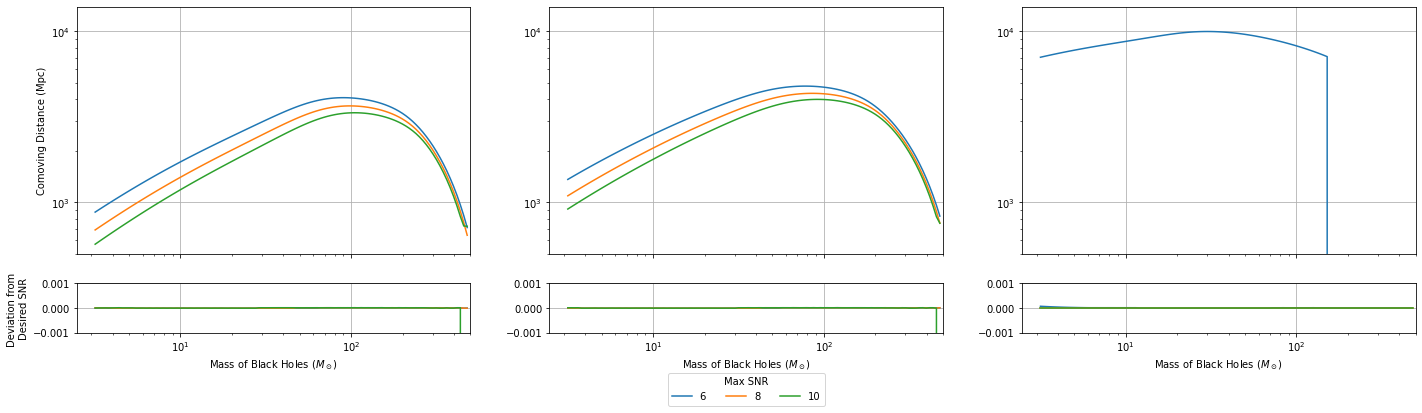

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(24,6), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

distlistaligo = [distlist6aligo, distlist8aligo, distlist10aligo]
distlistaplus = [distlist6aplus, distlist8aplus, distlist10aplus]
distlistcosmic = [distlist6cosmic, distlist8cosmic, distlist10cosmic]
distlist = [distlistaligo, distlistaplus, distlistcosmic]

for i in range(len(distlist)):
  for j in range(len(distlist[i])):
    axs[0, i].loglog(masslist, distlist[i][j])

for i in range(len(difflist)): 
  for j in range(len(difflist[i])):
    axs[1, i].plot(masslist, difflist[i][j])

for i in range(len(difflist)):
  axs[0,i].set_ylim([500, 14000])
  axs[0,i].set_xlim([0, 500])
  axs[0,i].grid()
  axs[1,i].set_ylim([-0.001, 0.001])
  axs[1,i].grid()

plt.setp(axs[-1, :], xlabel='Mass of Black Holes ($M_\odot$)')
plt.setp(axs[0, 0], ylabel='Comoving Distance (Mpc)')
plt.setp(axs[1,0], ylabel='Deviation from \nDesired SNR')

axs[1,1].legend(loc="lower center", bbox_to_anchor=(0.5, -1.5), borderaxespad=0.1, labels=['6', '8', '10'], title="Max SNR", ncol=3)

In [ ]:
## Plot the same thing as above but using maximum redshift vs. mass instead

zvals6aligo, zvals6aplus, zvals6cosmic, zvals8aligo, zvals8aplus, zvals8cosmic, zvals10aligo, zvals10aplus, zvals10cosmic = ([0] * len(masslist[i]) for i in range(len(masslist
                                                                                                                                                                       
                                                                                                                                                                       
                                                                                                                                                                       )))

zvallistaligo = [zvals6aligo, zvals8aligo, zvals10aligo]
zvallistaplus = [zvals6aplus, zvals8aplus, zvals10aplus]
zvallistcosmic = [zvals6cosmic, zvals8cosmic, zvals10cosmic]
zvallist = [zvallistaligo, zvallistaplus, zvallistcosmic]

for i in range(len(zvallist)):
  for m in range(len(zvallist[i])):
    for k in range(len(zvallist[i][m])):
      zvallist[i][m][k] = 1 + z_at_value(Planck18.comoving_distance, distlist[i][m][k] * u.Mpc)

NameError: ignored

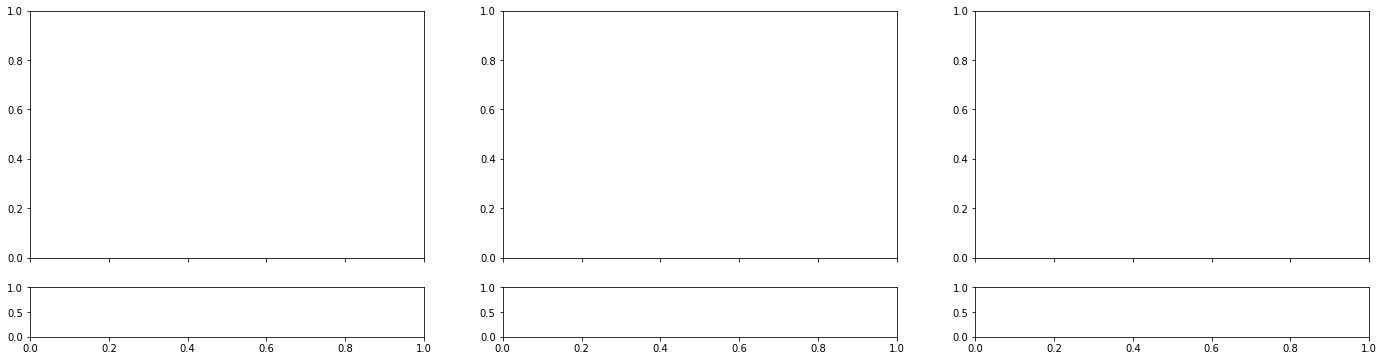

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(24,6), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

for i in range(len(zvallist)):
  for j in range(len(zvallist[i])):
    axs[0, i].plot(masslist, zvallist[i][j])

for i in range(len(difflist)): 
  for j in range(len(difflist[i])):
    axs[1, i].plot(masslist, difflist[i][j])

for i in range(len(difflist)):
  axs[0,i].set_ylim([1, 80])
  axs[0,i].set_yscale('log')
  axs[0,i].set_xlim([0, 500])
  axs[0,i].grid(color='0.6')
  axs[0,i].grid(b=True, which='minor', linestyle='dotted', color='0.75')
  axs[1,i].set_ylim([-10**-4, 10**-4])
  axs[1,i].grid()

plt.setp(axs[-1, :], xlabel='Mass of Black Holes ($M_\odot$)')
plt.setp(axs[0, 0], ylabel='Maximum z-value')
plt.setp(axs[1,0], ylabel='Deviation from \nDesired SNR')

axs[1,1].legend(loc="lower center", bbox_to_anchor=(0.5, -1.5), borderaxespad=0.1, labels=['6', '8', '10'], title="Max SNR", ncol=3)

In [ ]:
## Heatmap simulation comparing mass ratio and total mass (aLIGO Design Sensitivity)

massratio = np.arange(1, 10, 0.2)
totalmass = np.arange(1, 3, 0.05)
totalmass = 10**totalmass

distances = np.zeros((len(massratio), len(totalmass)))
diff = np.zeros((len(massratio), len(totalmass)))

for r in range(len(massratio)):
  for t in range(len(totalmass)):
    distances[r][t], diff[r][t] = estimate_distance(snr=8, guess=600, alpha=-20, iterations=200, tolerance=0.001,
                                        mass1=totalmass[t]*(massratio[r] / (massratio[r]+1)), mass2=totalmass[t] / (massratio[r]+1), spin1=[0,0,0], spin2=[0,0,0],
                                        tmass1=totalmass[t]*(massratio[r] / (massratio[r]+1)), tmass2=totalmass[t] / (massratio[r]+1), tspin1=[0,0,0], tspin2=[0,0,0],
                                        res=1.0/1024, fres=1.0/16, flow=20, psd='aLIGODesignSensitivityP1200087')
    
    print("Total mass: {}, Mass ratio: {}".format(totalmass[t], massratio[r]))


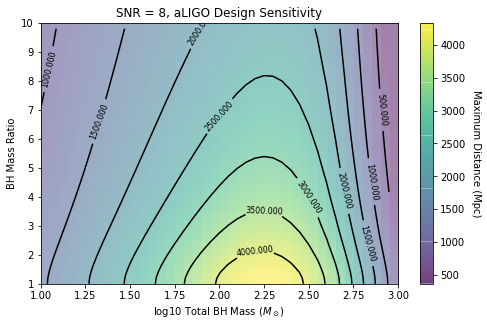

In [ ]:
contours = plt.contour(np.log10(totalmass), massratio, distances, 7, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(distances, origin='lower', cmap='viridis', alpha=0.5, extent=[1.0, 3.0, 1, 10], aspect='auto')

plt.xlabel("log10 Total BH Mass $(M_\odot)$")
plt.ylabel("BH Mass Ratio")
plt.title("SNR = 8, aLIGO Design Sensitivity")

cbar = plt.colorbar()
cbar.set_label('Maximum Distance (Mpc)', rotation=270, labelpad=15)

plt.rcParams["figure.figsize"] = (8, 4.8)

In [ ]:
## Heatmap simulation comparing mass ratio and total mass (APlus Design Sensitivity)

massratio = np.arange(1, 10, 0.2)
totalmass = np.arange(1, 3, 0.05)
totalmass = 10**totalmass

distances = np.zeros((len(massratio), len(totalmass)))
diff = np.zeros((len(massratio), len(totalmass)))

for r in range(len(massratio)):
  for t in range(len(totalmass)):
    distances[r][t], diff[r][t] = estimate_distance(snr=8, guess=1000, alpha=-50, iterations=100, tolerance=0.001,
                                        mass1=totalmass[t]*(massratio[r] / (massratio[r]+1)), mass2=totalmass[t] / (massratio[r]+1), spin1=[0,0,0], spin2=[0,0,0],
                                        tmass1=totalmass[t]*(massratio[r] / (massratio[r]+1)), tmass2=totalmass[t] / (massratio[r]+1), tspin1=[0,0,0], tspin2=[0,0,0],
                                        res=1.0/1024, fres=1.0/16, flow=20, psd='aLIGOAPlusDesignSensitivityT1800042')
    
    print("Total mass: {}, Mass ratio: {}".format(totalmass[t], massratio[r]))


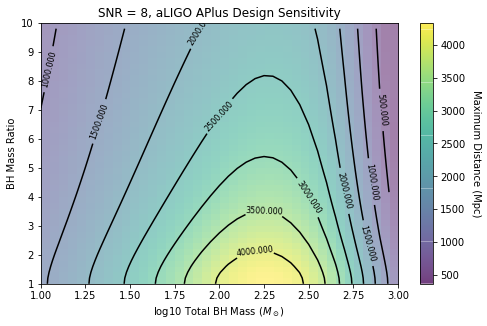

In [ ]:
contours = plt.contour(np.log10(totalmass), massratio, distances, 8, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(distances, origin='lower', cmap='viridis', alpha=0.5, extent=[1.0, 3.0, 1, 10], aspect='auto')

plt.xlabel("log10 Total BH Mass $(M_\odot)$")
plt.ylabel("BH Mass Ratio")
plt.title("SNR = 8, aLIGO APlus Design Sensitivity")

cbar = plt.colorbar()
cbar.set_label('Maximum Distance (Mpc)', rotation=270, labelpad=15)

plt.rcParams["figure.figsize"] = (8, 4.8)

In [ ]:
## Heatmap simulation comparing mass ratio and total mass (Cosmic Explorer Design Sensitivity)

massratio = np.arange(1, 10, 0.2)
totalmass = np.arange(1, 3, 0.05)
totalmass = 10**totalmass

distances = np.zeros((len(massratio), len(totalmass)))
diff = np.zeros((len(massratio), len(totalmass)))

for t in range(len(totalmass)):
  for r in range(len(massratio)):
    distances[r][t], diff[r][t] = estimate_distance(snr=8, guess=9000-2*totalmass[t]**1.2, alpha=-50, iterations=100, tolerance=0.001,
                                        mass1=totalmass[t]*(massratio[r] / (massratio[r]+1)), mass2=totalmass[t] / (massratio[r]+1), spin1=[0,0,0], spin2=[0,0,0],
                                        tmass1=totalmass[t]*(massratio[r] / (massratio[r]+1)), tmass2=totalmass[t] / (massratio[r]+1), tspin1=[0,0,0], tspin2=[0,0,0],
                                        res=1.0/1024, fres=1.0/16, flow=20, psd='CosmicExplorerP1600143')
    
    print("Total mass: {}, Mass ratio: {}".format(totalmass[t], massratio[r]))




In [ ]:
## Cover upper range with a lower alpha

for t in range(25, len(totalmass)):
  for r in range(len(massratio)):
    distances[r][t], diff[r][t] = estimate_distance(snr=8, guess=10000-10*totalmass[t], alpha=-8, iterations=1000, tolerance=0.001,
                                        mass1=totalmass[t]*(massratio[r] / (massratio[r]+1)), mass2=totalmass[t] / (massratio[r]+1), spin1=[0,0,0], spin2=[0,0,0],
                                        tmass1=totalmass[t]*(massratio[r] / (massratio[r]+1)), tmass2=totalmass[t] / (massratio[r]+1), tspin1=[0,0,0], tspin2=[0,0,0],
                                        res=1.0/1024, fres=1.0/16, flow=20, psd='CosmicExplorerP1600143')
    
    print("Total mass: {}, Mass ratio: {}".format(totalmass[t], massratio[r]))

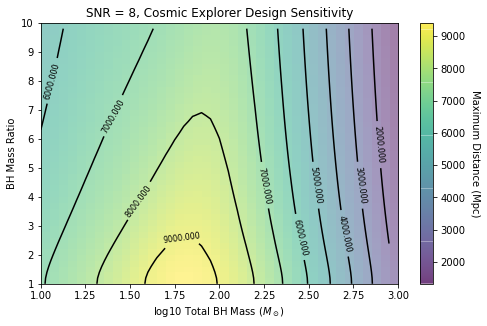

In [ ]:
contours = plt.contour(np.log10(totalmass), massratio, distances, 8, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(distances, origin='lower', cmap='viridis', alpha=0.5, extent=[1.0, 3.0, 1, 10], aspect='auto')

plt.xlabel("log10 Total BH Mass $(M_\odot)$")
plt.ylabel("BH Mass Ratio")
plt.title("SNR = 8, Cosmic Explorer Design Sensitivity")

cbar = plt.colorbar()
cbar.set_label('Maximum Distance (Mpc)', rotation=270, labelpad=15)

plt.rcParams["figure.figsize"] = (8, 4.8)